# HW 2 - Multilayer Perceptron
## Jennifer Bryson

The goal of this assignment is to implement a multilayer perceptron (aka feed-forward artificial neural network) with two layers (i.e. one hidden layer) and logistic transfer functions.  I will use online back-propagation of error as the learning algorithm.

I will vary the parameters: learning rate and number of iterations.  For each value of the parameters, I report average error of the algorithm on both a training set and a test set, along with statistical error bars on those quantities.

Lastly, for the best network, I will show a visual representation (similar to a heat map) of the final trained weights.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 1 the ANN will solve: "exactly-one-on"
Our data input will be a vector $x \in R^{20}$ whose entries are either 0 or 1.  If $x$ has exactly one 1, then the target output will be 1.  If $x$ does not have exactly one 1, then the target output will be 0.

First, let's generate some data keeping in mind the following things:
1. We need a lot of training data, say 500 vectors.

1. We must guarantee that we have training data vectors that have exactly-one-on (since they make up just $\frac{20}{2^{20}}$ possible vectors).

1. Furthermore, since there are only 20 vectors that have exactly-one-on (out of $2^{20}$ possible vectors), we need to make sure they have a good chance of being picked by our stochastic weight update process, so let's repeat these vectors in our training data to boost their chance of being selected.

Therefore, we'll pick $16*30 = 480$ total training vectors, where a third of the data comes from exactly-one-on data (so we'll pick 16 of the exactly-one-on vectors and include them each 10 times, making $16*10$ vectors of this form).

In [2]:
dim_of_data_point = 20
num_train = 16*30
# each row of x will be a data vector, and we will make sure to have 8 vectors with exactly one 1
x = np.vstack((np.random.randint(2, size=(num_train-16*10,dim_of_data_point)), \
               [[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]]*10, \
               [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]]*10))

Now we'll add a column of 1's to the front of $x$ so we can simply dot product a row of $x$ with weights and not have to deal with adding the constant term that allows for linear combinations not through the origin.

In [3]:
xhat = np.hstack((np.ones((num_train,1)), x))

Before we get too far, let's make some training data that is NOT in the test data.  Again, add a 1 to the front of the vector.

In [4]:
#exactly-one-on points NOT in training set:
test_eoo = [[1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]
for i in range(num_train):
    for k in range(4):
        if np.linalg.norm(test_eoo[k] - xhat[i,:])==0:
            print "Bad luck! One of these test exactly-one-on points happened to be in your training set"

num_noo_tests=16*20  #noo stands for not-one-on
test_noo = np.hstack((np.ones((num_noo_tests,1)), np.random.randint(2, size=(num_noo_tests,dim_of_data_point))))
for k in range(num_noo_tests):
    for i in range(num_train):
        if np.linalg.norm(test_noo[k] - xhat[i,:])==0:
            print 'bad row is row number', k

Great!  We didn't happen to get unlucky and randomly select testing points that happened to be in our set of training points.  If you run this and find that one of them is bad, then delete it using np.delete(test_noo, k, 0) and remember to then adjust num_noo_tests.

Similarly, we'll want to store our exactly-one-on training points.

In [5]:
#let's store which exactly-one-one training points we used so later we can find accuracy from within the training set
train_eoo = [[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],\
             [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
             [1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0], \
             [1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0], \
             [1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0], \
             [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0], \
             [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0], \
             [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]]

Now we will choose how many nodes we'll put in the hidden layer, say M=10.  And we'll initialize the weights for the first layer to come from a standard Gaussian.  Similarly, we'll initialize the weights for the second layer.

Note on dimension of the weight matrices for each layer:
<br>
&nbsp; &nbsp; $\bullet$ The number of rows of the weight matrix = the number of nodes you want in the next layer
<br>
&nbsp; &nbsp; $\bullet$ The number of columns of the weight matrix = 1 + the number of nodes you had in the previous layer

In [6]:
# I changed my mind and added this to the training funtion since we need to re-initialize the weights for each
# time we train the weights, but I left this code block for understanding the setup-purpose.

M=10
#w_layer_1 = np.random.randn(M,dim_of_data_point+1)  # num rows = how many things you want in the next layer, num columns = 1+num things you have in current layer
#w_layer_2 = np.random.randn(1,M+1)

We'll need our logistic transfer function, which I'm going to name sigmoid:

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

We're all set up!  Now we will use stochastic gradient descent to train the weights.  Specifically, for each iteration, we randomly pick a training point.  We send that training point through the network.  Then we will find the partial derivative of the error function for each weight ($\frac{\partial E}{\partial w_{j,i}}$) by back-propagation, and update $w_{j,i} = w_{j,i}-\eta \frac{\partial E}{\partial w_{j,i}}$ where $\eta$ is the learning rate (which we will vary).  We will also vary the number of iterations we allow.

In [3]:
def feed_forward(x, w_layer_1, w_layer_2):  #put in a vector of length 1+dim_of_data_point whose first entry is a 1
    a_layer_1 = np.zeros((1,M))
    for i in range(M):
        a_layer_1[0,i] = np.dot(w_layer_1[i,:],x)
    
    z = np.zeros((1,M))
    for i in range(M):
        z[0,i] = sigmoid(a_layer_1[0,i])
    zhat = np.hstack((np.ones((1,1)),z)) #add a one in front to allow for linear functions not through the origin
    #return zhat.shape

    a_layer_2 = np.dot(w_layer_2,zhat.T)
    y = sigmoid(a_layer_2) #the output of the feed-forward
    return y, a_layer_2, zhat, a_layer_1

In [9]:
def mlp_training(num_iter,eta):
    
    #we'll need to clear the weights each time we do a run
    M=10
    w_layer_1 = np.random.randn(M,dim_of_data_point+1)  # num rows = how many things you want in the next layer, num columns = 1+num things you have in current layer
    w_layer_2 = np.random.randn(1,M+1)

    for l in range(num_iter):
        rand_train = np.random.randint(num_train) #select a random number from 0 to 459
        train = xhat[rand_train,:] # pick out that random training point for your stochatic gradient descent
        ff = feed_forward(train, w_layer_1, w_layer_2)
        if np.linalg.norm(train) == np.sqrt(2): # if the training point has exactly one on
            #update layer_1 weights
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j+1]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

        else:
            #update layer_1 weights
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * ff[0][0,0] *sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * ff[0][0,0]*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

    return w_layer_1,w_layer_2


Now we'll make a function that evaluates how accurate our trained weights are.  Notice that I defined accuracy in an abnormal way.  I didn't want to simply have the accuracy be $\frac{\#correctly\_classified}{total\_number}$ because this wouldn't be a good measure for this problem.  For example, I could've forced the output to always be 0, which would be correct $\frac{2^{20}-20}{2^{20}} = 0.99998\%$ of the time, but that doesn't solve our classification problem at all since it classifies everything the same!  Therefore, I chose to make the accuracy be the average given by: $\frac{1}{2}\frac{\#\_correctly\_classified\_exactly\_one\_on}{total\_\#\_exactly\_one\_on\_tests} + \frac{1}{2} \frac{\#\_correctly\_classifed\_not\_one\_on}{total\_\#\_not\_one\_on\_tests}$ 

In [10]:
def accuracy(w_layer_1, w_layer_2):
    #accuracy of exactly-one-on points NOT in training set:
    test_eoo_count = 0
    for i in range(4):
        if feed_forward(test_eoo[i], w_layer_1, w_layer_2)[0][0,0] >=0.5:
            test_eoo_count = test_eoo_count +1
    #print 'Percentage of TEST exactly-one-on points that are correctly classified is', float(test_eoo_count)/float(4)

    #accuracy of exactly-one-on points IN training set:
    train_eoo_count = 0
    for i in range(16):
        if feed_forward(train_eoo[i], w_layer_1, w_layer_2)[0][0,0] >=0.5:
            train_eoo_count = train_eoo_count +1
    #print 'Percentage of TRAIN exactly-one-on points that are correctly classified is', float(train_eoo_count)/float(16)

    #accuracy of not-one-on points NOT in training set:
    test_noo_count = 0
    for i in range(num_noo_tests):
        if feed_forward(test_noo[i], w_layer_1, w_layer_2)[0][0,0] < 0.5 and np.linalg.norm(test_noo[i]) != np.sqrt(2):
            test_noo_count = test_noo_count+1
        elif feed_forward(test_noo[i], w_layer_1, w_layer_2)[0][0,0] >= 0.5 and np.linalg.norm(test_noo[i]) == np.sqrt(2):
            test_noo_count = test_noo_count+1
        else:
            test_noo_count = test_noo_count
    #print 'Percentage of TEST random (most likely not-one-on) points that are correctly classified is', float(test_noo_count)/float(num_noo_tests)

    #accuracy of not-one-on points IN training set:
    train_noo_count = 0
    for i in range(16*20):
        if feed_forward(xhat[i], w_layer_1, w_layer_2)[0][0,0] < 0.5 and np.linalg.norm(xhat[i]) != np.sqrt(2):
            train_noo_count = train_noo_count+1
        elif feed_forward(xhat[i], w_layer_1, w_layer_2)[0][0,0] >= 0.5 and np.linalg.norm(xhat[i]) == np.sqrt(2):
            train_noo_count = train_noo_count+1
        else:
            train_noo_count = train_noo_count
    #print 'Percentage of TRAIN random (most likely not-one-on) points that are correctly classified is', float(train_noo_count)/float(16*20)

    train_accuracy = 0.5*float(train_eoo_count)/float(16)+0.5*float(train_noo_count)/float(16*20)
    test_accuracy = 0.5*float(test_eoo_count)/float(4)+0.5*float(test_noo_count)/float(num_noo_tests)
    
    return train_accuracy, test_accuracy

In [11]:
w_layer_1,w_layer_2 = mlp_training(500,0.7)
train_acc, test_acc = accuracy(w_layer_1,w_layer_2)

print train_acc, test_acc

0.99375 0.9890625


Great!  We can train our weights and then find the testing/training data accuracy by running the two simple lines above!  Now we'll make 3 loops: 
1. for choosing the learning rate (eta), 
1. for choosing how many iterations we update the weights, and
1. for repeating the trial with the same eta and same number of iterations so that we can get the mean percentage of accuracy and standard deviation.

*NOTE: the following code block takes about 10 minutes to run.  If you'd like to make it faster, just change the "5" in the first line to a "2".  This will only loop over two iteration choices (specifically the smaller iteration choices), so it'll be much faster (a few minutes).  You'll have to adjust the table created below too then.  Or alternatively, you can just change the iter_choices to be smaller numbers, but the smaller the number, the worse the accuracy.  Another way to speed it up is to change $repeat\_trial$ to be a smaller number (like 2 or 3) so that we average over fewer repeat trials per $(eta,\#\_iterations)$ pair.

In [12]:
num_iter_choices = 5
iter_choices = [100,250,500,750,1000]

num_learning_rates = 6
learning_rates = [1.8,1.5,1.2,0.9,0.6,0.3]

train_mean = np.zeros((num_iter_choices,num_learning_rates))
train_std = np.zeros((num_iter_choices,num_learning_rates))
test_mean = np.zeros((num_iter_choices,num_learning_rates))
test_std = np.zeros((num_iter_choices,num_learning_rates))

for i in range(num_iter_choices):  #loop over iteration choicies
    for j in range(num_learning_rates):  #loop over learning rates
        repeat_trial = 5  #we'll repeat the trial 5 different times so we can get a mean and std for these parameters
        train_acc = np.zeros((1,repeat_trial))
        test_acc = np.zeros((1,repeat_trial))
        for k in range(repeat_trial):
            w_layer_1,w_layer_2 = mlp_training(iter_choices[i],learning_rates[j])
            train_acc[0,k], test_acc[0,k] = accuracy(w_layer_1,w_layer_2)
        train_mean[i,j] = np.mean(train_acc)
        train_std[i,j] = np.std(train_acc)
        test_mean[i,j] = np.mean(test_acc)
        test_std[i,j] = np.std(test_acc)

In [13]:
print train_mean
print
print test_mean

[[ 0.93625    0.8371875  0.8284375  0.74375    0.78375    0.613125 ]
 [ 0.994375   0.990625   0.9765625  0.9596875  0.869375   0.788125 ]
 [ 0.9959375  0.9896875  0.9953125  0.916875   0.9321875  0.8565625]
 [ 0.998125   0.9959375  0.994375   0.996875   0.9634375  0.943125 ]
 [ 0.999375   0.9975     0.9978125  0.9959375  0.9940625  0.953125 ]]

[[ 0.8825     0.7896875  0.81       0.7259375  0.7496875  0.5578125]
 [ 0.995      0.94       0.9421875  0.900625   0.886875   0.8365625]
 [ 0.99625    0.9903125  0.996875   0.893125   0.9471875  0.8328125]
 [ 0.996875   0.995625   0.991875   0.998125   0.9809375  0.8996875]
 [ 0.998125   0.998125   0.9984375  0.995625   0.9921875  0.9225   ]]


Lastly, we put all our results into tables.  One table for how accurately the algorithm classifies the testing data, and a second table for how accurately the algorithm classifies the training data.

In [14]:
test_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        test_result_str[i][j] = str(round(test_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(test_std[i,j], 3))

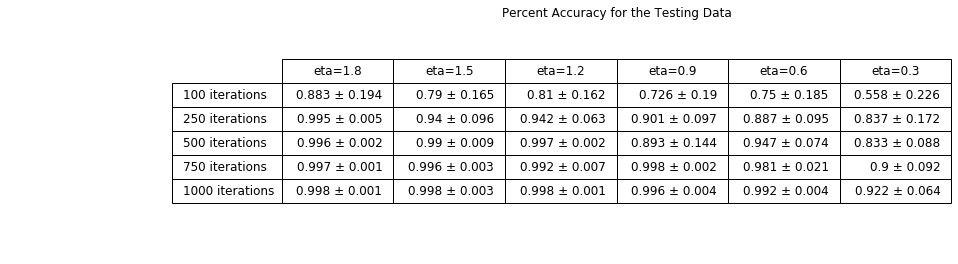

In [15]:
#make a table whose entries are strings of the mean +/- the std for each eta and number of iterations pair
fig = plt.figure() 
ax = fig.add_subplot(111)
col_labels = ('eta=1.8', 'eta=1.5', 'eta=1.2', 'eta=0.9', 'eta=0.6', 'eta=0.3')
row_labels = ['100 iterations', '250 iterations', '500 iterations', '750 iterations', '1000 iterations']

the_table = plt.table(cellText=test_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Testing Data")

plt.show()
#fig.savefig('Name.pdf')

In [16]:
train_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        train_result_str[i][j] = str(round(train_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(train_std[i,j], 3))

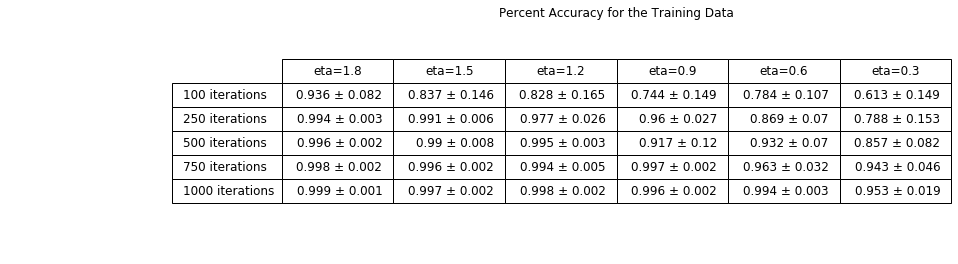

In [17]:
#make a table whose entries are strings of the mean +/- the std for each eta and number of iterations pair
fig = plt.figure() 
ax = fig.add_subplot(111)
col_labels = ('eta=1.8', 'eta=1.5', 'eta=1.2', 'eta=0.9', 'eta=0.6', 'eta=0.3')
row_labels = ['100 iterations', '250 iterations', '500 iterations', '750 iterations', '1000 iterations']

the_table = plt.table(cellText=train_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Training Data")

plt.show()
#fig.savefig('Name.pdf')

We see that the accuracy on the testing data and on the training data are comparable.  This is very good, as it signifies that we have not overfit our model to the training data.

Let's display some of the information from the TESTING data accuracy table into graphs:

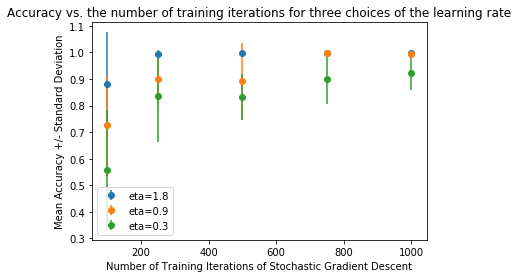

In [18]:
x = [100,250,500,750,1000]

#plt.figure()
eta18 = plt.errorbar(x, test_mean[:,0], test_std[:,0], fmt='o', label='eta=1.8') 
eta09 = plt.errorbar(x, test_mean[:,3], test_std[:,3], fmt='o', label='eta=0.9') 
eta03 = plt.errorbar(x, test_mean[:,5], test_std[:,5], fmt='o', label='eta=0.3') 
plt.legend(handles=[eta18,eta09,eta03])
plt.xlabel('Number of Training Iterations of Stochastic Gradient Descent')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. the number of training iterations for three choices of the learning rate")
plt.show()

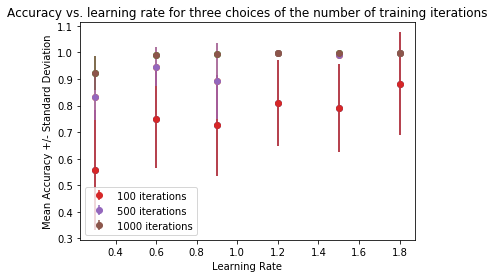

In [20]:
x = [0.3,0.6,0.9,1.2,1.5,1.8] #eta values from SMALLEST to largest

#plt.figure()
iter100 = plt.errorbar(x, test_mean[0,:][::-1], test_std[0,:][::-1], fmt='o', label='100 iterations')  #the [::-1] part reads off the list in reverse order, so graphically smaller eta is on the left
iter500 = plt.errorbar(x, test_mean[2,:][::-1], test_std[2,:][::-1], fmt='o', label='500 iterations') 
iter1000 = plt.errorbar(x, test_mean[4,:][::-1], test_std[4,:][::-1], fmt='o', label='1000 iterations') 
plt.legend(handles=[iter100,iter500,iter1000])
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. learning rate for three choices of the number of training iterations")
plt.show()

The figures clearly show that when we choose a really small learning rate, we need many more iterations to get a good level of accuracy.  For a large number of iterations such as 1,000 iterations, all of the learning rates (except the very smallest, eta=0.3) did really well.  However, given fewer iterations, only the larger learning rates did well since the smaller learning rates didn't have enough time to reach the minimum in the gradient descent. 

Overall, we see that choosing the number of iterations and the learning rate cannot be choosen independently; picking a small number of iterations forces you to need a larger learning rate, and picking a small learning rate forces you to need a larger number of iterations.  Of course a small learning rate and huge number of iterations is probably ideal, but that would take a ton of computational power.

Now let's get a good run of the code to collect good weight values so we can plot them like a heat map.

In [21]:
w_layer_1,w_layer_2 = mlp_training(1000,1.8)
train_acc, test_acc = accuracy(w_layer_1,w_layer_2)

print train_acc, test_acc

1.0 1.0


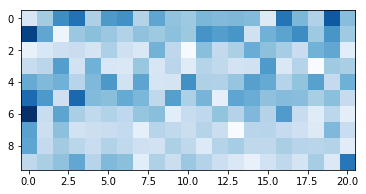

In [22]:
plt.imshow(w_layer_1, cmap='Blues')
plt.show()

Interestingly, it appears the bias weights (column 0) were very important.

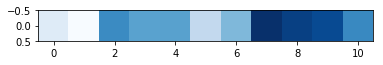

In [23]:
plt.imshow(w_layer_2, cmap='Blues')
plt.show()

***
### Problem 2 the ANN will solve: is the first entry a 1?
Our data input will be a vector $x \in R^{15}$ whose entries are either 0 or 1.  If $x$ has a 1 as its first entry, then the target output will be 1.  If $x$ has a 0 as its first entry, then the target output will be 0.

First, let's generate some data.  Notice that this data set is nicer than in Problem 1 in the sense that we can randomly pick vectors and 50% of them should have the first entry being a 1 and 50% the first entry being 0, so we don't need to "boost" the likelihood of our stocastic gradient descent picking one verses the other.

In [24]:
dim_of_data_point = 15
num_train = 500
# each row of x will be a data vector
x = np.random.randint(2, size=(num_train,dim_of_data_point))
#again add a ones column to the front of x to account for the "bias" aka linear combinations not though the origin
xhat = np.hstack((np.ones((num_train,1)), x))

#similarly, let's make some test data: 
#(I'm not going to bother checking if the random test data happened to be in the training data - it's highly unlikely)
num_test = 500
test = np.hstack((np.ones((num_test,1)), np.random.randint(2, size=(num_test,dim_of_data_point))))

#we'll choose M=10 nodes in hidden layer 1 again for simplicity
M=10

We can reuse the $feed\_forward$ and $sigmoid$ functions above, but we'll need to edit the $mlp\_training$ and $accuracy$ functions since we'll be training on different criteria and evaluating accuracy differently as well.  For the training function, we only have to edit the first if statement to be our new criteria for the target being a 1.  As for the accuracy, here the accuracy will be easier, we'll simply give it our random test data and get an overall accuracy (not bothering to force a certain number of tests of each parity since it will be roughly half of each naturally).

In [25]:
def mlp_training_2(num_iter,eta):
    
    #we'll need to clear the weights each time we do a run
    w_layer_1 = np.random.randn(M,dim_of_data_point+1)  # num rows = how many things you want in the next layer, num columns = 1+num things you have in current layer
    w_layer_2 = np.random.randn(1,M+1)

    for l in range(num_iter):
        rand_train = np.random.randint(num_train) #select a random number from 0 to 499
        train = xhat[rand_train,:] # pick out that random training point for your stochatic gradient descent
        ff = feed_forward(train, w_layer_1, w_layer_2)
        if train[1] == 1:
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j+1]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

        else:
            #update layer_1 weights
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * ff[0][0,0] *sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * ff[0][0,0]*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

    return w_layer_1,w_layer_2

In [26]:
def accuracy_2(w_layer_1, w_layer_2):
    #accuracy of training set:
    train_count = 0
    for i in range(num_train):
        #if you have 1 as your first entry
        if xhat[i,1] == 1:
            #if you were accurately labeled
            if feed_forward(xhat[i,:], w_layer_1, w_layer_2)[0][0,0] >= 0.5:
                train_count = train_count + 1
        else: # if you have 0 as your first entry
            #if you were accurately labeled
            if feed_forward(xhat[i,:], w_layer_1, w_layer_2)[0][0,0] < 0.5:
                train_count = train_count + 1
    train_accuracy = float(train_count)/float(num_train)
    #print 'Percentage of TRAINING points that are correctly classified is', train_accuracy
    
    #accuracy of testing set:
    test_count = 0
    for i in range(num_test):
        #if you have 1 as your first entry
        if test[i,1] == 1:
            #if you were accurately labeled
            if feed_forward(test[i,:], w_layer_1, w_layer_2)[0][0,0] >= 0.5:
                test_count = test_count + 1
        else: # if you have 0 as your first entry
            #if you were accurately labeled
            if feed_forward(test[i,:], w_layer_1, w_layer_2)[0][0,0] < 0.5:
                test_count = test_count + 1
    test_accuracy = float(test_count)/float(num_test)
    #print 'Percentage of TESTING points that are correctly classified is', test_accuracy

    return train_accuracy, test_accuracy

In [28]:
w_layer_1,w_layer_2 = mlp_training_2(750,1.5)
train_acc, test_acc = accuracy_2(w_layer_1,w_layer_2)

print train_acc, test_acc

1.0 1.0


Great!  It works!  Now we'll again loop over a variety of learning rates and number of iterations as we did before.

In [29]:
num_iter_choices = 5
iter_choices = [100,250,500,750,1000]

num_learning_rates = 6
learning_rates = [1.8,1.5,1.2,0.9,0.6,0.3]

train_mean = np.zeros((num_iter_choices,num_learning_rates))
train_std = np.zeros((num_iter_choices,num_learning_rates))
test_mean = np.zeros((num_iter_choices,num_learning_rates))
test_std = np.zeros((num_iter_choices,num_learning_rates))

for i in range(num_iter_choices):  #loop over iteration choicies
    for j in range(num_learning_rates):  #loop over learning rates
        repeat_trial = 4  #we'll repeat the trial 4 different times so we can get a mean and std for these parameters
        train_acc = np.zeros((1,repeat_trial))
        test_acc = np.zeros((1,repeat_trial))
        for k in range(repeat_trial):
            w_layer_1,w_layer_2 = mlp_training_2(iter_choices[i],learning_rates[j])
            train_acc[0,k], test_acc[0,k] = accuracy_2(w_layer_1,w_layer_2)
        train_mean[i,j] = np.mean(train_acc)
        train_std[i,j] = np.std(train_acc)
        test_mean[i,j] = np.mean(test_acc)
        test_std[i,j] = np.std(test_acc)

In [30]:
print train_mean
print
print test_mean

[[ 0.659   0.6255  0.7295  0.546   0.611   0.655 ]
 [ 0.868   0.7955  0.662   0.7005  0.766   0.8205]
 [ 0.9995  0.995   0.9725  0.8305  0.758   0.748 ]
 [ 1.      0.9975  0.877   0.997   0.959   0.8835]
 [ 1.      1.      1.      0.999   0.832   0.988 ]]

[[ 0.6485  0.6285  0.7515  0.5405  0.6005  0.658 ]
 [ 0.8695  0.8095  0.653   0.687   0.757   0.813 ]
 [ 0.9995  0.9945  0.9725  0.8235  0.7475  0.73  ]
 [ 1.      0.995   0.873   0.996   0.964   0.874 ]
 [ 1.      1.      1.      1.      0.824   0.985 ]]


In [31]:
#### TESTING DATA RESULTS
test_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        test_result_str[i][j] = str(round(test_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(test_std[i,j], 3))

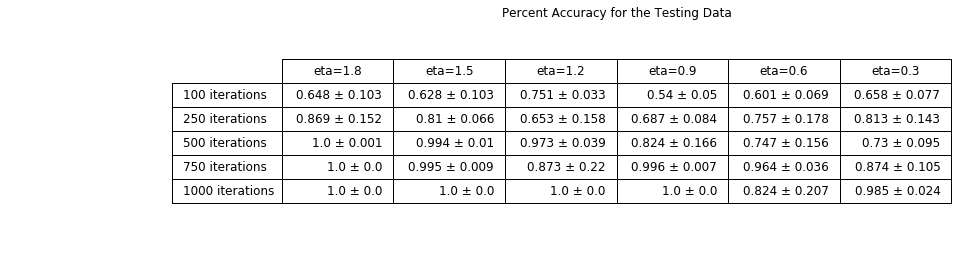

In [32]:
#table for the TESTING DATA RESULTS whose entries are strings of the mean +/- the std for each (eta, #iterations) pair
fig = plt.figure() 
ax = fig.add_subplot(111)
col_labels = ('eta=1.8', 'eta=1.5', 'eta=1.2', 'eta=0.9', 'eta=0.6', 'eta=0.3')
row_labels = ['100 iterations', '250 iterations', '500 iterations', '750 iterations', '1000 iterations']

the_table = plt.table(cellText=test_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Testing Data")

plt.show()
#fig.savefig('Name.pdf')

In [33]:
#### TRAINING DATA RESULTS
train_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        train_result_str[i][j] = str(round(train_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(train_std[i,j], 3))

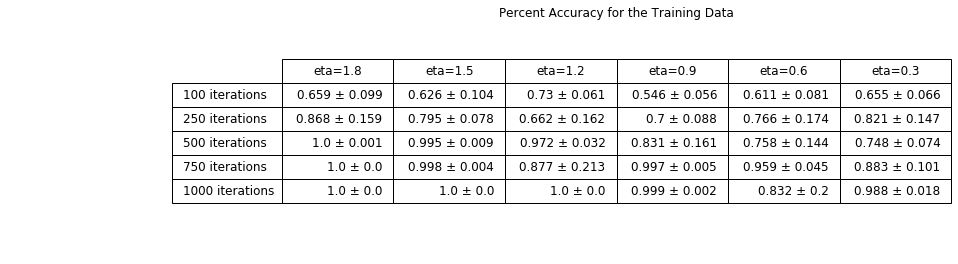

In [34]:
#table for the TRAINING DATA RESULTS whose entries are strings of the mean +/- the std for each (eta, #iterations) pair
fig = plt.figure() 
ax = fig.add_subplot(111)
col_labels = ('eta=1.8', 'eta=1.5', 'eta=1.2', 'eta=0.9', 'eta=0.6', 'eta=0.3')
row_labels = ['100 iterations', '250 iterations', '500 iterations', '750 iterations', '1000 iterations']

the_table = plt.table(cellText=train_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Training Data")

plt.show()
#fig.savefig('Name.pdf')

As in the first problem, our testing and training accuracy are comparable, which is a good sign!

Let's display some of the information from the TESTING data accuracy table into graphs:

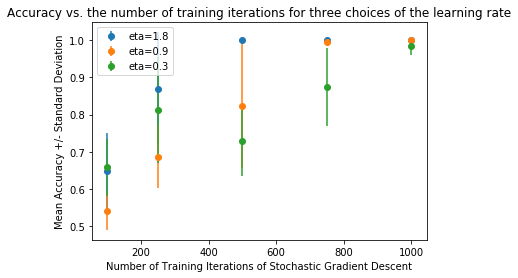

In [35]:
x = [100,250,500,750,1000]

#plt.figure()
eta18 = plt.errorbar(x, test_mean[:,0], test_std[:,0], fmt='o', label='eta=1.8') 
eta09 = plt.errorbar(x, test_mean[:,3], test_std[:,3], fmt='o', label='eta=0.9') 
eta03 = plt.errorbar(x, test_mean[:,5], test_std[:,5], fmt='o', label='eta=0.3') 
plt.legend(handles=[eta18,eta09,eta03])
plt.xlabel('Number of Training Iterations of Stochastic Gradient Descent')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. the number of training iterations for three choices of the learning rate")
plt.show()

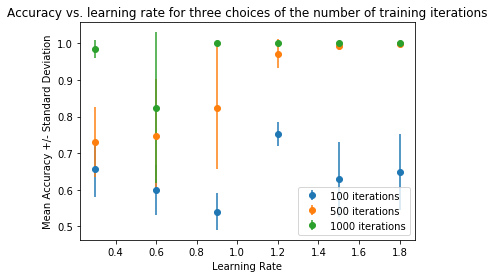

In [36]:
x = [0.3,0.6,0.9,1.2,1.5,1.8] #eta values SMALLEST to largest

#plt.figure()
iter100 = plt.errorbar(x, test_mean[0,:][::-1], test_std[0,:][::-1], fmt='o', label='100 iterations')  #the [::-1] part reads off the list in reverse order, so graphically smaller eta is on the left
iter500 = plt.errorbar(x, test_mean[2,:][::-1], test_std[2,:][::-1], fmt='o', label='500 iterations') 
iter1000 = plt.errorbar(x, test_mean[4,:][::-1], test_std[4,:][::-1], fmt='o', label='1000 iterations') 
plt.legend(handles=[iter100,iter500,iter1000])
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. learning rate for three choices of the number of training iterations")
plt.show()

This problem again shows the same relationship between choosing a learning rate and the number of iterations.  It appears that I should've considered even larger learning rates, which might allow for similar accuracy with fewer iterations.

Now let's get a good run of the code to collect good weight values so we can plot them like a heat map.

In [44]:
w_layer_1,w_layer_2 = mlp_training_2(1000,1.8)
train_acc, test_acc = accuracy_2(w_layer_1,w_layer_2)

print train_acc, test_acc

1.0 1.0


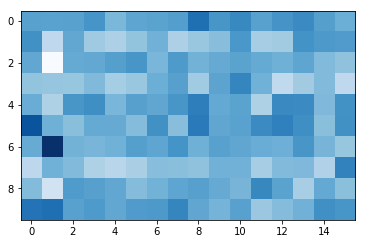

In [45]:
plt.imshow(w_layer_1, cmap='Blues')
plt.show()

As expected, column 1 is the most important, because this column is the weights that multiply against the first entry of the input, and for this problem, the first entry tells us everything.

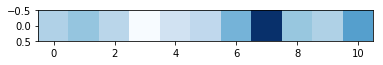

In [46]:
plt.imshow(w_layer_2, cmap='Blues')
plt.show()

Even more interesting: now the column 7 is the most useful, which we could've guessed from the heat map of the weights from layer 1 because the darkest spot in column 1 is row 6 (which later corresponds to column 7 of weights from layer 2 because we add a bias to the front of the vector).  Very cool to see it work!

***
### Problem 3 the ANN will solve: Image Classification
Our data input will be two black and white $5 \times 7$ images (one a giraffe head - imagination required - and the other $\pi$) with Gaussian noise added.  Specifically, we take a $5 \times 7$ "picture" made from twenty-six 0's and nine 1's.  We then flatten it into a vector $x \in R^{35}$ whose entries are either 0 or 1.  Then we add Gaussian mean 0, variance 0.3 to independently to each entry.  If $x$ came from the first image with noise added, then the target output will be 1.  If $x$ came from the second image with noise added, then the target output will be 0.

First, let's generate some data:

In [34]:
# make the training data:
dim_of_data_point = 35
alpha=0.3  #alpha in (0,1) -- smaller alpha makes each point cloud more tightly together
num_train=1000 #so 250 points per cluster...make sure you picked an even number!
center1 = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[1],[0],[1],[0],[0],[0],[1],[1],[1],[1],[1],[0],[0],[0],[1],[1],[1],[0],[0],[0],[0],[0],[1],[0],[0],[0]]
center2 = [[0],[0],[0],[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[0],[0],[0],[1],[0],[1],[0],[0],[0],[0],[1],[0],[1],[0],[0],[0],[0],[1],[0],[1],[0],[0]]
points_c1 = (alpha * np.random.randn(35,num_train/2) + center1).T
points_c2 = (alpha * np.random.randn(35,num_train/2) + center2).T  #each row of points_c2 is a noisy image of pi
points = np.vstack((points_c1, points_c2))
xhat = np.hstack((np.ones((num_train,1)), points))  #add ones to the front for bias purposes


#while we're at it, let's make some testing data:
num_test = 300
test_pts_c1 = (alpha * np.random.randn(35,num_test/2) + center1).T
test_pts_c2 = (alpha * np.random.randn(35,num_test/2) + center2).T  #each row of points_c2 is a noisy image of pi
test_points = np.vstack((test_pts_c1, test_pts_c2))
test = np.hstack((np.ones((num_test,1)), test_points))


#we'll choose M=15 nodes in hidden layer 1
M=10

First, let's take a look at the images I picked as the "centers":

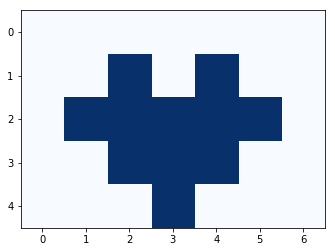

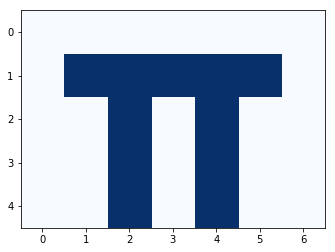

In [35]:
image1 = [[0,0,0,0,0,0,0],[0,0,1,0,1,0,0],[0,1,1,1,1,1,0],[0,0,1,1,1,0,0],[0,0,0,1,0,0,0]]
image2 = [[0,0,0,0,0,0,0],[0,1,1,1,1,1,0],[0,0,1,0,1,0,0],[0,0,1,0,1,0,0],[0,0,1,0,1,0,0]]
plt.imshow(image1, cmap='Blues')
plt.show()
plt.imshow(image2, cmap='Blues')
plt.show()

In [36]:
def mlp_training_3(num_iter,eta):
    
    #we'll need to clear the weights each time we do a run
    w_layer_1 = np.random.randn(M,dim_of_data_point+1)  # num rows = how many things you want in the next layer, num columns = 1+num things you have in current layer
    w_layer_2 = np.random.randn(1,M+1)

    for l in range(num_iter):
        rand_train = np.random.randint(num_train) #select a random number from 0 to 499
        train = xhat[rand_train,:] # pick out that random training point for your stochatic gradient descent
        ff = feed_forward(train, w_layer_1, w_layer_2)
        if rand_train < num_train/2:
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j+1]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * (ff[0][0,0]-1)*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

        else:
            #update layer_1 weights
            for j in range(M):
                for i in range(dim_of_data_point+1):
                    w_layer_1[j,i] = w_layer_1[j,i] - eta * ff[0][0,0] *sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) \
                    *w_layer_2[0,j]*sigmoid(ff[3][0,j])*(1-sigmoid(ff[3][0,j]))*train[i]
    
            #update layer_2 weights
            for j in range(M+1):
                w_layer_2[0,j] = w_layer_2[0,j] - eta * ff[0][0,0]*sigmoid(ff[1][0,0])*(1-sigmoid(ff[1][0,0])) * ff[2][0,j]

    return w_layer_1,w_layer_2

In [37]:
def accuracy_3(w_layer_1, w_layer_2):
    #accuracy of training set:
    train_count = 0
    for i in range(num_train):
        #if you have 1 as your first entry
        if i<num_train/2:
            #if you were accurately labeled
            if feed_forward(xhat[i,:], w_layer_1, w_layer_2)[0][0,0] >= 0.5:
                train_count = train_count + 1
        else: # if you have 0 as your first entry
            #if you were accurately labeled
            if feed_forward(xhat[i,:], w_layer_1, w_layer_2)[0][0,0] < 0.5:
                train_count = train_count + 1
    train_accuracy = float(train_count)/float(num_train)
    #print 'Percentage of TRAINING points that are correctly classified is', train_accuracy
    
    #accuracy of testing set:
    test_count = 0
    for i in range(num_test):
        #if you have 1 as your first entry
        if i<num_test/2:
            #if you were accurately labeled
            if feed_forward(test[i,:], w_layer_1, w_layer_2)[0][0,0] >= 0.5:
                test_count = test_count + 1
        else: # if you have 0 as your first entry
            #if you were accurately labeled
            if feed_forward(test[i,:], w_layer_1, w_layer_2)[0][0,0] < 0.5:
                test_count = test_count + 1
    test_accuracy = float(test_count)/float(num_test)
    #print 'Percentage of TESTING points that are correctly classified is', test_accuracy

    return train_accuracy, test_accuracy

In [38]:
w_layer_1,w_layer_2 = mlp_training_3(150,0.9)
train_acc, test_acc = accuracy_3(w_layer_1,w_layer_2)

print train_acc, test_acc

0.989 0.986666666667


Excellent!  It worked!  Now to loop over a variety of parameters as before.  This time, we find that we don't need as many iterations, even for the same size learning rates.

In [51]:
num_iter_choices = 4 
iter_choices = [10,50,100,150]

num_learning_rates = 6
learning_rates = [1.7,1.3,0.9,0.7,0.5,0.3] 

train_mean = np.zeros((num_iter_choices,num_learning_rates))
train_std = np.zeros((num_iter_choices,num_learning_rates))
test_mean = np.zeros((num_iter_choices,num_learning_rates))
test_std = np.zeros((num_iter_choices,num_learning_rates))

for i in range(num_iter_choices):  #loop over iteration choicies
    for j in range(num_learning_rates):  #loop over learning rates
        repeat_trial = 4  #we'll repeat the trial 4 different times so we can get a mean and std for these parameters
        train_acc = np.zeros((1,repeat_trial))
        test_acc = np.zeros((1,repeat_trial))
        for k in range(repeat_trial):
            w_layer_1,w_layer_2 = mlp_training_3(iter_choices[i],learning_rates[j])
            train_acc[0,k], test_acc[0,k] = accuracy_3(w_layer_1,w_layer_2)
        train_mean[i,j] = np.mean(train_acc)
        train_std[i,j] = np.std(train_acc)
        test_mean[i,j] = np.mean(test_acc)
        test_std[i,j] = np.std(test_acc)

In [52]:
print train_mean
print
print test_mean

[[ 0.6305   0.63225  0.697    0.54825  0.63325  0.5185 ]
 [ 0.87775  0.8095   0.83     0.75025  0.79425  0.64525]
 [ 0.9955   0.86425  0.96675  0.98325  0.87825  0.93025]
 [ 0.995    0.997    0.9715   0.804    0.92     0.9095 ]]

[[ 0.63416667  0.63333333  0.7025      0.53416667  0.62666667  0.5325    ]
 [ 0.86        0.80666667  0.8225      0.75833333  0.7775      0.62166667]
 [ 0.99833333  0.86583333  0.95833333  0.98333333  0.885       0.92166667]
 [ 0.99583333  0.99916667  0.96083333  0.8         0.93166667  0.91083333]]


In [53]:
#### TESTING DATA RESULTS
test_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        test_result_str[i][j] = str(round(test_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(test_std[i,j], 3))

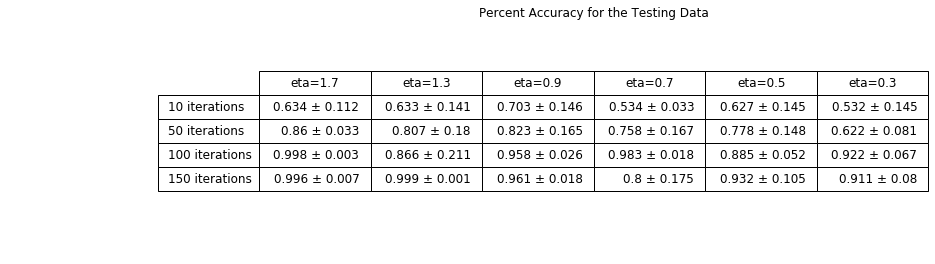

In [54]:
#table for the TESTING DATA RESULTS whose entries are strings of the mean +/- the std for each (eta, #iterations) pair
fig = plt.figure() 
ax = fig.add_subplot(111) 
col_labels = ('eta=1.7', 'eta=1.3', 'eta=0.9', 'eta=0.7', 'eta=0.5', 'eta=0.3')
row_labels = ['10 iterations', '50 iterations', '100 iterations', '150 iterations'] 

the_table = plt.table(cellText=test_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Testing Data")

plt.show()
#fig.savefig('Name.pdf')

In [55]:
#### TRAINING DATA RESULTS
train_result_str = [['','','','','',''],['','','','','',''],['','','','','',''],['','','','','','']]

for i in range(num_iter_choices):
    for j in range(num_learning_rates):
        train_result_str[i][j] = str(round(train_mean[i,j], 3)) + " " + u"\u00B1"  + " " + str(round(train_std[i,j], 3))

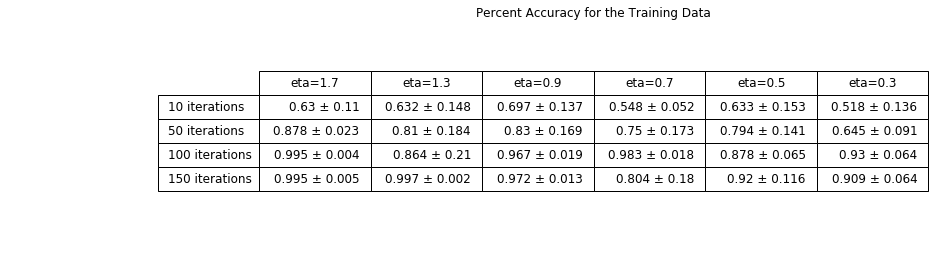

In [56]:
#table for the TRAINING DATA RESULTS whose entries are strings of the mean +/- the std for each (eta, #iterations) pair
fig = plt.figure() 
ax = fig.add_subplot(111) 
col_labels = ('eta=1.7', 'eta=1.3', 'eta=0.9', 'eta=0.7', 'eta=0.5', 'eta=0.3')
row_labels = ['10 iterations', '50 iterations', '100 iterations', '150 iterations']

the_table = plt.table(cellText=train_result_str,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.set_fontsize(30)
the_table.scale(2, 2)
ax.axis("off")
plt.title("Percent Accuracy for the Training Data")

plt.show()
#fig.savefig('Name.pdf')

Again, our testing and training accuracy are comparable, which is a good sign!

Let's display some of the information from the TESTING data accuracy table into graphs:

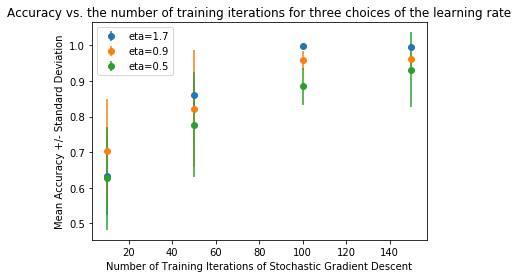

In [57]:
x = [10,50,100,150]

#plt.figure()
eta17 = plt.errorbar(x, test_mean[:,0], test_std[:,0], fmt='o', label='eta=1.7') 
eta09 = plt.errorbar(x, test_mean[:,2], test_std[:,2], fmt='o', label='eta=0.9') 
eta05 = plt.errorbar(x, test_mean[:,4], test_std[:,4], fmt='o', label='eta=0.5') 
plt.legend(handles=[eta17,eta09,eta05])
plt.xlabel('Number of Training Iterations of Stochastic Gradient Descent')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. the number of training iterations for three choices of the learning rate")
plt.show()

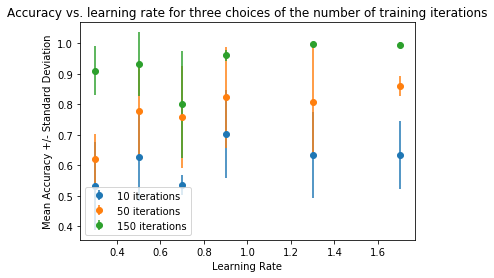

In [58]:
x = [0.3,0.5,0.7,0.9,1.3,1.7] #eta values  SMALLEST TO LARGEST

#plt.figure()
iter10 = plt.errorbar(x, test_mean[0,:][::-1], test_std[0,:][::-1], fmt='o', label='10 iterations')  #the [::-1] part reads off the list in reverse order, so graphically smaller eta is on the left
iter50 = plt.errorbar(x, test_mean[1,:][::-1], test_std[1,:][::-1], fmt='o', label='50 iterations') 
iter150 = plt.errorbar(x, test_mean[3,:][::-1], test_std[3,:][::-1], fmt='o', label='150 iterations') 
plt.legend(handles=[iter10,iter50,iter150])
plt.xlabel('Learning Rate')
plt.ylabel('Mean Accuracy +/- Standard Deviation')
plt.title("Accuracy vs. learning rate for three choices of the number of training iterations")
plt.show()

This problem again shows the same relationship between choosing a learning rate and the number of iterations.  It appears that I really should've considered even larger learning rates, which might allow for similar accuracy with fewer iterations.

Now let's make a heat map of the weights for a good collection of weights.  First we make such "good weights".

In [44]:
w_layer_1,w_layer_2 = mlp_training_3(200,1.7)
train_acc, test_acc = accuracy_3(w_layer_1,w_layer_2)

print train_acc, test_acc

0.999 1.0


Now if we simply displayed the weights for layer 1, we'd have get a heat map that has 10 $\times$ 36 boxes, the first column is the bias weight (to allow linear combinations not through the origin), and the remaining 35 columns relate to weights applied to a certain "pixel" of the 5 $\times$ 7 image; e.g. columns 2-8 are the weights that go to the top row of the image.  Thus we see that instead of displaying the weights in layer 1 as a 10 $\times$ 36 map, it's more informative to make each row into a 5$\times$7 matrix and give all the bias weights separately.  We do this now.

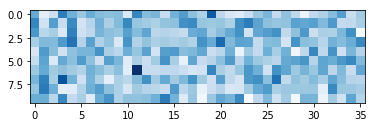

In [51]:
# this simply shows all of the weights from layer 1 as a 10x36 matrix.
plt.imshow(w_layer_1, cmap='Blues')
plt.show()

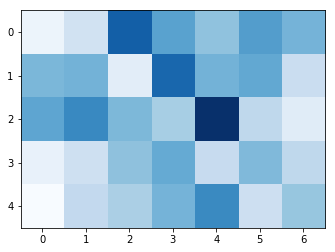

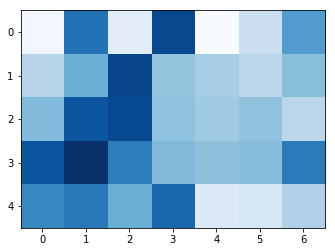

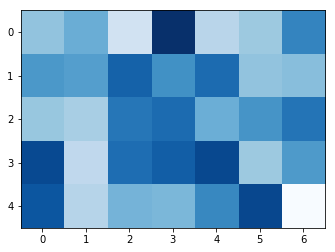

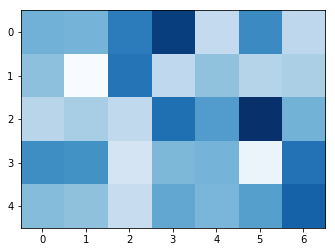

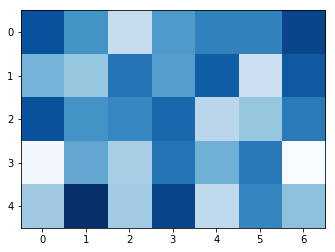

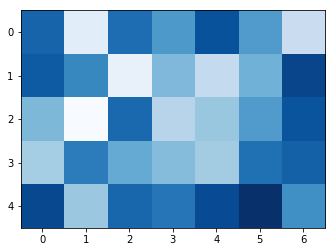

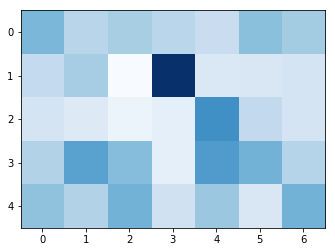

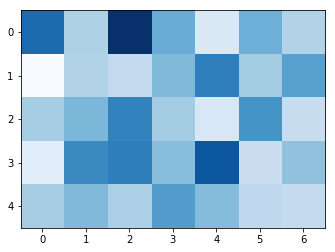

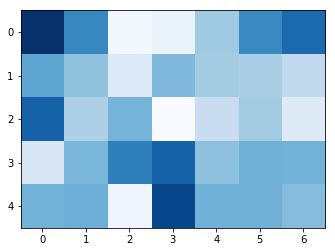

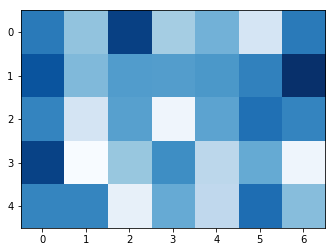

In [54]:
for i in range(M):
    plt.imshow(np.reshape(w_layer_1[i,1:36],(5,7)), cmap='Blues')
    plt.show()

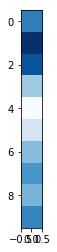

In [47]:
# here are the weights for the bias components
plt.imshow(np.reshape(w_layer_1[:,0],(10,1)), cmap='Blues')
plt.show()

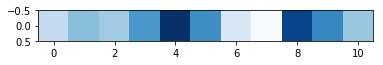

In [48]:
#lastly, we show the weights from layer 2
plt.imshow(w_layer_2, cmap='Blues')
plt.show()

So what did we learn from this?  From the layer 2 weights, we see that the 5th column is the heaviest weighted.  So now we'll look back at the 4th image of weights (4th because the first column of weights_layer_2 is for the bias), and we expect to see dark spots in places where the two original images differ.  Indeed, this is true.  Very cool to visualize!